# Clustering des documents et analyse des communautés dans le graphe


In [2]:
# Imports des bibliothèques et modules nécessaires
import os
import sys
import pandas as pd
import networkx as nx
from pathlib import Path

from scipy.cluster.vq import kmeans
from sklearn.metrics import silhouette_score
import numpy as np
from community import community_louvain
import nltk
# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')


# Ajouter le répertoire parent au chemin de recherche
sys.path.append(os.path.abspath('..'))

# Import des modules du projet
from src.config.config import load_config
from src.data_acquisition.data_loader import DataLoader
from src.clustering.text_clusterer import TextClusterer
from src.clustering.graph_clusterer import GraphClusterer
from src.clustering.label_generator import LabelGenerator
from src.search_engine.indexer import Indexer
from src.graph_analysis.graph_viz import GraphVisualizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL_7670\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Chargement des données prétraitées

Par manque de ressources (suite au plantage d'une ram, je manquais de mémoire), ici nous limitons l'expérimentation à la moitié des données ayant à la fois des abstracts et des références

In [3]:
# Charger la configuration
config = load_config()

# Chemin vers le fichier de données prétraitées
processed_data_path = Path("../data/processed/corpus_preprocessed.json")

# Vérifier le fichier avec une expression plus concise
if not processed_data_path.exists():
    raise FileNotFoundError(f"Le fichier {processed_data_path} n'existe pas.")

# Charger les données directement
cleaned_docs = DataLoader(config).load_from_json(processed_data_path)

# Filtrer en une seule étape et ne garder que la moitié
cleaned_docs = [
    doc for doc in cleaned_docs
    if doc.get("abstract", "").strip() and doc.get("references")  # Filtrage des documents valides
]

# Afficher un aperçu des données filtrées
print(f"Documents après filtrage: {len(cleaned_docs)}")
pd.DataFrame(cleaned_docs).head()

Documents après filtrage: 32290


,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,purpose develop tool high school student study...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,international conference on human-computer int...,purpose develop tool high school student study...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
2,visual analytics science and technology,describes implementation methodology visualisa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
3,visual analytics science and technology,describes implementation methodology visualisa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
4,pattern recognition and machine intelligence,article applied garch instead ar arma compare ...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4


## 2. Clustering des documents textuels (ex: KMeans)

In [4]:
# Créer un indexeur et construire l'index
indexer = Indexer(config)
index_stats = indexer.build_index(cleaned_docs, content_field='abstract')

# Créer un clusteriseur textuel
text_clusterer = TextClusterer(indexer)

# Appliquer le clustering KMeans
print("Application du clustering KMeans...")
kmeans_clusters = text_clusterer.cluster_kmeans(n_clusters=8)
print("clustering Kmeans effectué !")

Application du clustering KMeans...
clustering Kmeans effectué !


## 3. Clustering du graphe de citations (Louvain, Spectral, Label Propagation)

In [4]:
# Construire un graphe de citation
from src.graph_analysis.graph_builder import GraphBuilder

graph_builder = GraphBuilder(cleaned_docs)
citation_graph = graph_builder.build_citation_graph()

# Convertir en graphe non dirigé pour Louvain
undirected_graph = citation_graph.to_undirected()

# Créer un clusteriseur de graphe
graph_clusterer = GraphClusterer(undirected_graph)

# Appliquer l'algorithme de Louvain
print("Application de Louvain...")
louvain_clusters = graph_clusterer.cluster_louvain()

# Appliquer le clustering spectral
print("Application du clustering spectral...")
spectral_clusters = graph_clusterer.cluster_spectral(n_clusters=5)

# Appliquer Label Propagation
print("Application de Label Propagation...")
label_clusters = graph_clusterer.cluster_label_propagation()

Graphe construit avec 16145 nœuds et 1564 arêtes.
Application de Louvain...
Application du clustering spectral...
Application de Label Propagation...


## 4. Vérifier les résultats du clustering

In [6]:
# Vérifier que chaque clustering s'est bien passé et a donné des clusters
print(f"Nombre de clusters trouvés avec KMeans: {len(kmeans_clusters)}")
print(f"Nombre de clusters trouvés avec Louvain: {len(louvain_clusters)}")
print(f"Nombre de clusters trouvés avec Spectral Clustering: {len(spectral_clusters)}")
print(f"Nombre de clusters trouvés avec Label Propagation: {len(label_clusters)}")

Nombre de clusters trouvés avec KMeans: 8
Nombre de clusters trouvés avec Louvain: 14649
Nombre de clusters trouvés avec Spectral Clustering: 5
Nombre de clusters trouvés avec Label Propagation: 14745


## 5. Caractériser le clustering textuel par Kmeans (des abstracts)

In [8]:
# Créer un générateur d'étiquettes
from src.clustering.label_generator import LabelGenerator
from src.search_engine.indexer import Indexer

# D'abord créer un indexeur si ce n'est pas déjà fait
indexer = Indexer(config)
index_stats = indexer.build_index(cleaned_docs, content_field='abstract')

# Initialiser le générateur d'étiquettes
label_generator = LabelGenerator(indexer, cleaned_docs)

# Générer les termes les plus représentatifs pour les clusters
print("\nTermes représentatifs des clusters par kmeans:")
for cluster_id, doc_ids in kmeans_clusters.items():
    top_terms = label_generator.get_top_terms(doc_ids, top_n=10)
    print(f"Cluster {cluster_id}: {', '.join([term[0] for term in top_terms])}")

# Générer les termes discriminants pour un cluster spécifique
cluster_id = list(kmeans_clusters.keys())[1]  # Premier cluster
discriminative_terms = label_generator.get_discriminative_terms(kmeans_clusters[cluster_id], num_terms=10)
print(f"\nTermes discriminants pour le cluster {cluster_id}:")
for term, score in discriminative_terms:
    print(f"- {term}: {score:.4f}")


Termes représentatifs des clusters par kmeans:
Cluster 1: social, development, technology, support, business, management, environment, student, project, tool
Cluster 2: classification, recognition, speech, classifier, experiment, accuracy, training, pattern, clustering, class
Cluster 6: software, architecture, tool, program, implementation, environment, code, control, memory, parallel
Cluster 0: object, motion, segmentation, detection, video, visual, shape, robot, region, human
Cluster 4: graph, search, given, constraint, space, optimization, bound, optimal, linear, class
Cluster 7: query, web, semantic, document, search, retrieval, ontology, text, word, database
Cluster 5: agent, logic, reasoning, theory, rule, representation, domain, action, semantics, relation
Cluster 3: protocol, scheme, node, security, attack, sensor, wireless, key, communication, mobile

Termes discriminants pour le cluster 1:
- social: 0.0174
- student: 0.0148
- business: 0.0145
- technology: 0.0145
- developme

In [10]:
# Générer les termes discriminants pour un autre cluster  (ici sur la classe computer vision)
cluster_id = list(kmeans_clusters.keys())[3]  # Cluster 0 dans l'affichage précédent
discriminative_terms = label_generator.get_discriminative_terms(kmeans_clusters[cluster_id], num_terms=10)
print(f"\nTermes discriminants pour le cluster {cluster_id}:")
for term, score in discriminative_terms:
    print(f"- {term}: {score:.4f}")


Termes discriminants pour le cluster 0:
- object: 0.0426
- motion: 0.0255
- segmentation: 0.0235
- detection: 0.0192
- shape: 0.0184
- video: 0.0179
- camera: 0.0172
- scene: 0.0171
- visual: 0.0170
- surface: 0.0160


## 6. Identifier les documents les plus représentatifs d'un cluster issu de Kmeans sur abstracts:

In [13]:
# Créer un TextClusterer et appliquer KMeans
from src.clustering.text_clusterer import TextClusterer
# Créer un clusteriseur textuel
text_clusterer = TextClusterer(indexer)
# Appliquer le clustering KMeans
kmeans_clusters = text_clusterer.cluster_kmeans(n_clusters=8)

In [14]:
# Trouver les documents les plus proches du centre pour le cluster de computer vision
cluster_id = 0  # Cluster à analyser
print(f"\n[INFO] Identification des documents les plus représentatifs du cluster {cluster_id}...")
representative_docs = text_clusterer.get_closest_documents_to_center(cluster_id, top_n=5)

# Utiliser un ensemble pour traquer les documents déjà affichés
displayed_docs = set()

print(f"\n[INFO] Documents les plus représentatifs du cluster {cluster_id}:")
for doc_id in representative_docs:
    # Vérifier si le document a déjà été affiché
    if doc_id in displayed_docs:
        print(f"[ATTENTION] Document {doc_id} déjà affiché précédemment, ignoré.")
        continue

    # Ajouter à l'ensemble des documents affichés
    displayed_docs.add(doc_id)

    # Trouver le document correspondant dans filtered_docs (pas cleaned_docs)
    doc = next((d for d in cleaned_docs if d.get('id') == doc_id), None)
    if doc:
        print(f"- ID: {doc_id}")
        print(f"  Titre: {doc.get('title', 'Sans titre')}")
        print(f"  Auteurs: {', '.join(doc.get('authors', []))}")
        print(f"  Année: {doc.get('year', 'N/A')}")
        print(f"  Classe: {doc.get('class', 'N/A')}")

        # Afficher un extrait du résumé
        abstract = doc.get('abstract', '')
        if abstract:
            print(f"  Résumé (extrait): {abstract[:150]}...")
        print()
    else:
        print(f"[ERREUR] Document avec ID {doc_id} non trouvé dans le jeu de données.")


[INFO] Identification des documents les plus représentatifs du cluster 0...

[INFO] Documents les plus représentatifs du cluster 0:
- ID: d4d71cb2-5da9-4c2b-b634-ab4b3794c05b
  Titre: Analyzing Periodic Motion Classification
  Auteurs: Xavier Orriols, Xavier Binefa
  Année: 2003
  Classe: 4
  Résumé (extrait): separating type periodic motion video sequence consider motion periodic pattern many fundamental frequency select temporal fourier transform pixel rep...

[ATTENTION] Document d4d71cb2-5da9-4c2b-b634-ab4b3794c05b déjà affiché précédemment, ignoré.
- ID: 83b2942d-85a5-4555-98e5-dd6bb473b348
  Titre: Camera motion estimation and moving object detection based on local feature tracking
  Auteurs: Andrey Vavilin, Le-My Ha, Kang-Hyun Jo
  Année: 2012
  Classe: 7
  Résumé (extrait): describes camera motion estimation moving object detection via tracking local region sequence consists part first sequence compose triangular grid ver...

[ATTENTION] Document 83b2942d-85a5-4555-98e5-dd6bb4

## 7. Visualisation de 8 clusters de Louvain avec T-snee (avec les résultats Louvain)

Filtrage des clusters pour la visualisation...


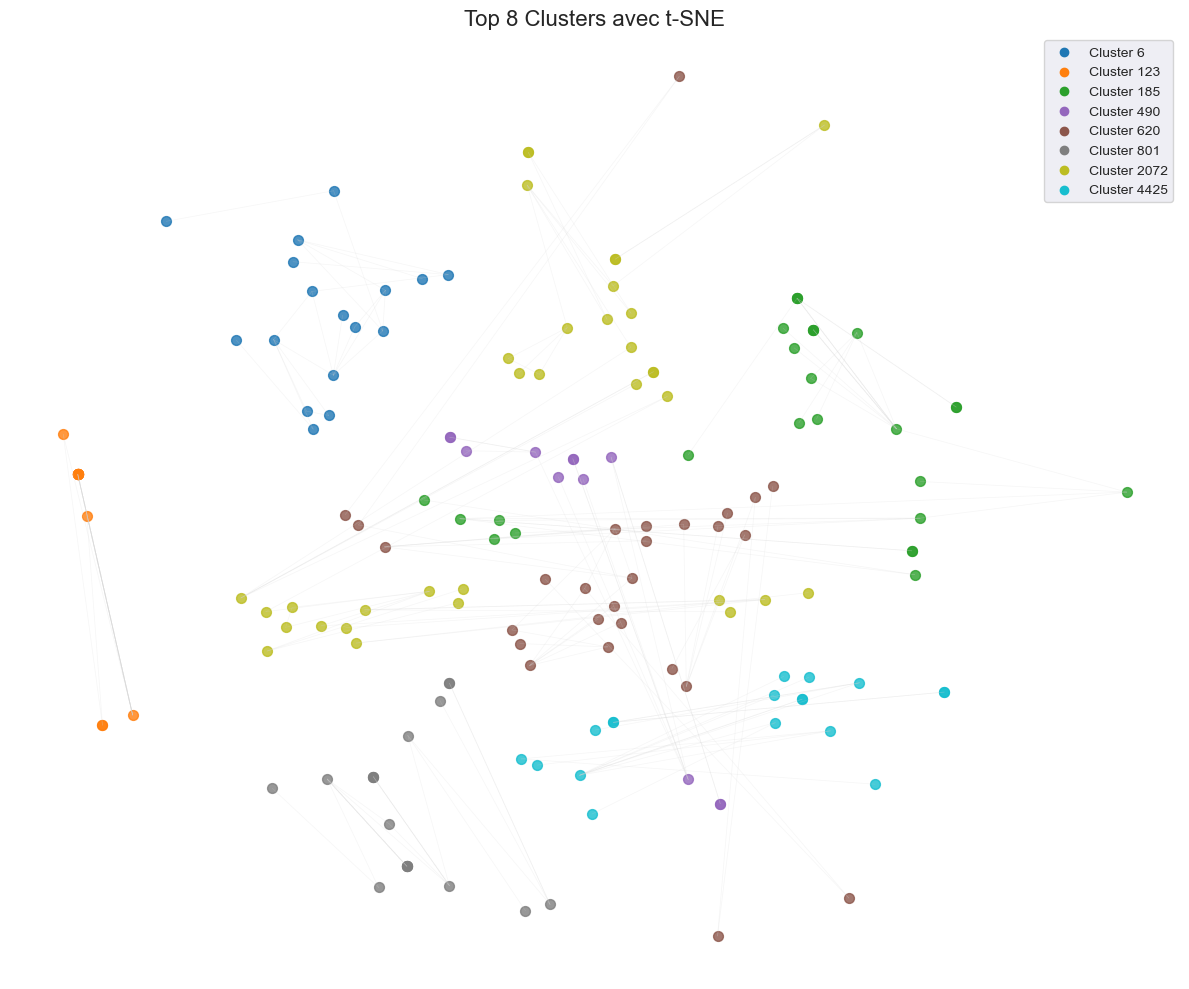

In [25]:
from src.graph_analysis.graph_viz import GraphVisualizer
import networkx as nx


# Filtrer les 8 plus grands clusters de Louvain pour la visualisation
print("Filtrage des clusters pour la visualisation...")
cluster_sizes = {c: len(nodes) for c, nodes in louvain_clusters.items()}
top_clusters = sorted(cluster_sizes.keys(), key=lambda c: cluster_sizes[c], reverse=True)[:8]

# Extraire les nœuds des clusters sélectionnés
top_nodes = [node for c in top_clusters for node in louvain_clusters[c]]

# Créer un sous-graphe avec ces nœuds
subgraph = undirected_graph.subgraph(top_nodes)

# Créer un dictionnaire associant chaque nœud à son cluster Louvain
node_to_cluster = {node: cluster_id for cluster_id in top_clusters for node in louvain_clusters[cluster_id]}

# Appeler la fonction de visualisation directement avec le graphe
GraphVisualizer.visualize_graph_tsne(subgraph, node_to_cluster, title="Top 8 Clusters avec t-SNE", perplexity=9)

## 9. Analyse de la modularité pour les communautés Louvain

In [26]:
# Calculer la modularité du partitionnement de Louvain
try:
    # Utiliser la fonction de modularité de NetworkX
    from networkx.algorithms.community import modularity

    # Convertir les clusters en format attendu par modularity
    communities = []
    for cluster_id, nodes in louvain_clusters.items():
        communities.append(set(nodes))

    # Calculer la modularité
    mod_score = modularity(undirected_graph, communities)
    print(f"\nModularité du partitionnement Louvain: {mod_score:.4f}")

    # Analyser les 5 plus grandes communautés
    top_communities = sorted(communities, key=len, reverse=True)[:5]
    for i, community in enumerate(top_communities):
        print(f"Communauté {i}: {len(community)} nœuds")
except ImportError:
    print("Fonction de modularité de NetworkX non disponible")


Modularité du partitionnement Louvain: 0.9968
Communauté 0: 34 nœuds
Communauté 1: 27 nœuds
Communauté 2: 27 nœuds
Communauté 3: 18 nœuds
Communauté 4: 18 nœuds


## 10. Croisement entre clusters Label Propagation et clusters Louvain

In [6]:
# Créer un dictionnaire pour mapper les IDs de documents à leurs clusters
label_doc_to_cluster = {}
for cluster_id, doc_ids in label_clusters.items():
    for doc_id in doc_ids:
        label_doc_to_cluster[doc_id] = cluster_id

# Créer un dictionnaire similaire pour Louvain
louvain_doc_to_cluster = {}
for cluster_id, doc_ids in louvain_clusters.items():
    for doc_id in doc_ids:
        louvain_doc_to_cluster[doc_id] = cluster_id

# Identifier les documents présents dans les deux clusterings
common_docs = set(label_doc_to_cluster.keys()) & set(louvain_doc_to_cluster.keys())
print(f"\nNombre de documents présents dans les deux clusterings: {len(common_docs)}")

# Créer un DataFrame pour analyser la correspondance
overlap_data = []
for doc_id in common_docs:
    overlap_data.append({
        'doc_id': doc_id,
        'label_cluster': label_doc_to_cluster[doc_id],
        'louvain_cluster': louvain_doc_to_cluster[doc_id]
    })

overlap_df = pd.DataFrame(overlap_data)

# Trouver les 8 plus grands clusters pour chaque méthode
label_cluster_sizes = overlap_df['label_cluster'].value_counts()
louvain_cluster_sizes = overlap_df['louvain_cluster'].value_counts()

top_8_label_clusters = label_cluster_sizes.nlargest(8).index.tolist()
top_8_louvain_clusters = louvain_cluster_sizes.nlargest(8).index.tolist()

# Filtrer le DataFrame pour ne garder que les documents dans les 8 plus grands clusters
filtered_overlap_df = overlap_df[
    (overlap_df['label_cluster'].isin(top_8_label_clusters)) &
    (overlap_df['louvain_cluster'].isin(top_8_louvain_clusters))
]

# Analyser la distribution croisée des clusters filtrés
cross_table = pd.crosstab(
    filtered_overlap_df['label_cluster'],
    filtered_overlap_df['louvain_cluster'],
    margins=True,
    normalize='index'
)

print("\nDistribution croisée des 8 plus grands clusters (pourcentage par ligne):")
print(cross_table)

# Calculer la matrice d'intersection brute (non normalisée) pour voir les tailles réelles
intersection_matrix = pd.crosstab(
    filtered_overlap_df['label_cluster'],
    filtered_overlap_df['louvain_cluster']
)

print("\nNombre d'éléments à l'intersection des 8 plus grands clusters:")
print(intersection_matrix)


Nombre de documents présents dans les deux clusterings: 16145

Distribution croisée des 8 plus grands clusters (pourcentage par ligne):
louvain_cluster       106       123       185       490       620
label_cluster                                                    
123              0.000000  1.000000  0.000000  0.000000  0.000000
491              0.000000  0.000000  0.000000  1.000000  0.000000
621              0.000000  0.000000  0.000000  0.000000  1.000000
1038             1.000000  0.000000  0.000000  0.000000  0.000000
2094             0.000000  0.000000  1.000000  0.000000  0.000000
All              0.177778  0.244444  0.222222  0.177778  0.177778

Nombre d'éléments à l'intersection des 8 plus grands clusters:
louvain_cluster  106  123  185  490  620
label_cluster                           
123                0   11    0    0    0
491                0    0    0    8    0
621                0    0    0    0    8
1038               8    0    0    0    0
2094               0    0

## Sauvegarde des résultats

In [ ]:
# Sauvegarde des résultats
output_dir = "../data/processed/"
os.makedirs(output_dir, exist_ok=True)

# Sauvegarde des clusters textuels
import json
json_path = os.path.join(output_dir, "text_clusters.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(kmeans_clusters, f, indent=4)
print(f"Clusters textuels enregistrés en JSON : {json_path}")

# Sauvegarde des clusters de graphe en GraphML
graphml_path = os.path.join(output_dir, "graph_clusters.graphml")
nx.write_graphml(citation_graph, graphml_path)
print(f"Clusters de graphe enregistrés en GraphML : {graphml_path}")